# Sparsity in Llama3

I instrument the Llama3 code to save some of the intermediate activations and to
set the small activations to zero. The code for this instrumentation is
[available here](https://github.com/a-rahimi/transformers).

In this notebook, I use this instrumentation to check what proportion of
actiivations are small and that the output of Llama3 doesn't change when I set
these to zero.

In [1]:
import matplotlib.pyplot as plt
import torch
import transformers

## v2 models
# model_path = "openlm-research/open_llama_3b_v2"
model_path = "openlm-research/open_llama_7b_v2"

## v1 models
# model_path = 'openlm-research/open_llama_3b'
# model_path = 'openlm-research/open_llama_7b'
# model_path = 'openlm-research/open_llama_13b'

print("Loading model & tokenizer...")
tokenizer = transformers.LlamaTokenizer.from_pretrained(model_path)
model = transformers.LlamaForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float32,
    device_map="cpu",
    attn_implementation="eager",
)

print("Tokenizing query...")
input_ids = tokenizer(
    "Q: How much wood would a wookchuck chuck if a woodchuck could chuck wood? A:",
    return_tensors="pt",
).input_ids

Loading model & tokenizer...


You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenizing query...


In [3]:
len(model.model.layers)

32

## Introduction

This Llama3 model has 32 transformer decoder layers.  Within each transformer
decoder layer, there is a self-attention sublayer, followed by a linear sublayer
and a GELU activation (called MLP1 below), then another linear sublayer (called
MLP2 below) with no non-linearity.

We'll examine the sparsity of the activation patterns of these sublayers during
the prefill phase. This is the phase where the model fills the KV cache based on
the prompt, right before it starts to autoregressively emit tokens. I focus on
this phase because it's compute-bound, whereas the subseuent autoregressive
phase is bound by memory transfers.

I show in two different ways that there is only around 25% sparsity we can
exploit from the MLP1 layer. There is about 70% sparsity to exploit in the
attention layer. I show this in two ways: by actually zeroing out numbers in the
layers and confirming that the model's output doesn't change, and by plotting
statistics of the activations in the original model.


## Zeroing out Small Activations

The cell below evaluates Llama3 so that attention weights and activations after MLP1 
smaller than 10% of the mean activation are set to zero:

In [ ]:
model.config.nuke_small_mlp1_activations = 0.1
model.config.nuke_small_attn_weights = 0.1
decoded_text_with_sparse_model = tokenizer.decode(
    model.generate(input_ids=input_ids, max_length=40).squeeze(0)
)

Compare against the original model that keeps all the activations:

In [4]:
model = transformers.LlamaForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float32,
    device_map="cpu",
    attn_implementation="eager",
)

model.config.nuke_small_mlp1_activations = None
model.config.nuke_small_attn_weights = None
decoded_text_with_full_model = tokenizer.decode(
    model.generate(input_ids=input_ids, max_length=40).squeeze(0)
)
print(decoded_text_with_full_model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

<s>Q: How much wood would a wookchuck chuck if a woodchuck could chuck wood? A: A wookchuck would chuck as much wood as a woodchuck could


Confirm they returned the same results:

In [5]:
assert decoded_text_with_sparse_model == decoded_text_with_full_model

# Histograms of Activations

This section shows activation statistics of the original model.

The plot below is the historgram of the activations right after the SiLU in the GELU activation (what I called MLOP1) of the 15th decoder layer:

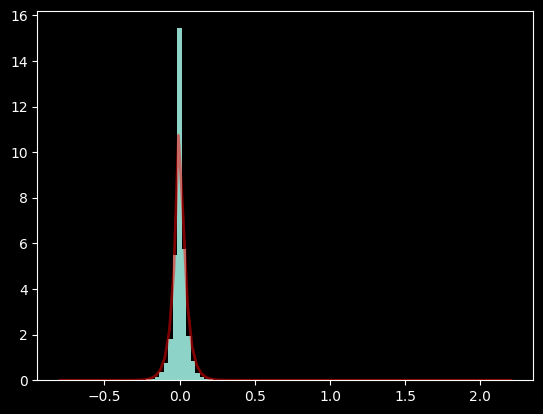

In [9]:
import numpy as np
import scipy.stats

activations = model.model.layers[15].mlp.mlp1.squeeze()[11]
plt.hist(activations, 100, density=True)

pdf = scipy.stats.laplace(*scipy.stats.laplace.fit_loc_scale(activations))
t = np.linspace(activations.min(), activations.max(), 100)
plt.plot(t, pdf.pdf(t), lw=2, color="red", alpha=0.5)
None

There is a huge spike near zero, which is promising. This spike is sharper than
the spike you'd observe under the Laplace distribution, which indicates a lot of
sparsity. But as well see below, this isn't the sparsity boon I am hoping for.
Less than 10% of the activations are <0.1 times the standard deviation of the
activations:

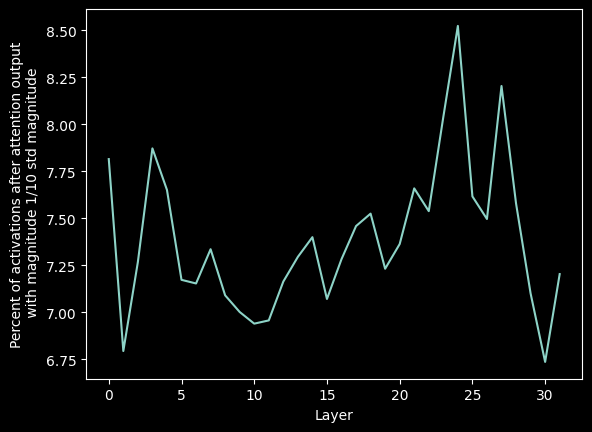

In [17]:
def relative_zeros(x: torch.Tensor, rtol=0.1) -> float:
    return (x.abs() < x.abs().mean() * rtol).to(float).mean()


plt.plot([100 * relative_zeros(layer.attn_output) for layer in model.model.layers])
plt.xlabel("Layer")
plt.ylabel(
    "Percent of activations after attention output\n with magnitude 1/10 std magnitude"
)
None

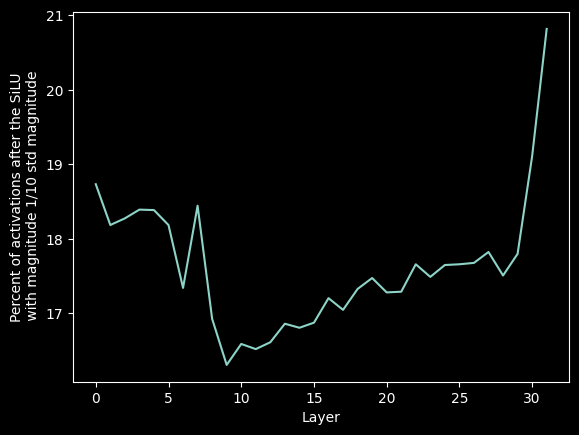

In [18]:
plt.plot([100 * relative_zeros(layer.mlp.mlp1) for layer in model.model.layers])
plt.xlabel("Layer")
plt.ylabel("Percent of activations after the SiLU\n with magnitude 1/10 std magnitude")
None

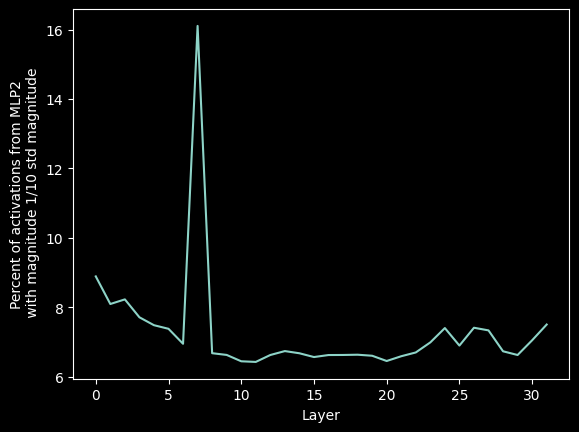

In [19]:
plt.plot(
    [100 * relative_zeros(layer.mlp.mlp2) for layer in model.model.layers],
)
plt.xlabel("Layer")
plt.ylabel("Percent of activations from MLP2\n with magnitude 1/10 std magnitude")
None

However, the attention matrix itself (a matrix deep inside the self attention block) has a lot of sparsity. First, it's lower-triangular, but even within the lower triangle, there are a lot of zeros.

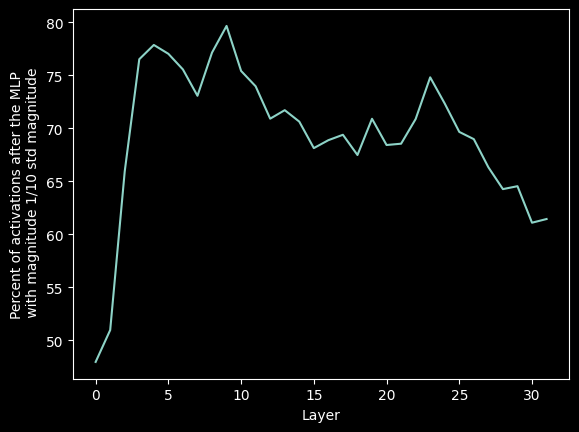

In [20]:
plt.plot([100 * relative_zeros(layer.attn_weights) for layer in model.model.layers])
plt.xlabel("Layer")
plt.ylabel("Percent of activations after the MLP\n with magnitude 1/10 std magnitude")
None

Here is the attention matrix from head 10 of the layer 15. Notice that there are plenty of zeros even in the lower triangle:

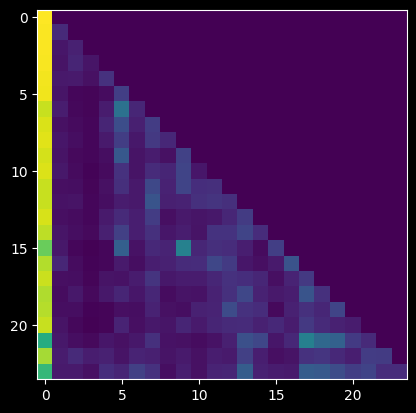

In [16]:
plt.imshow(model.model.layers[15].attn_weights.squeeze(0)[10] ** 0.5)
None